In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
def classify1(features, MX=5):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        print(BIC[i])
        if BIC[i] < lowest_bic:
            lowest_bic = BIC[i]
            best_gmm = gmm

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type='full', random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

def classify2(features, MX, MN=1):
    parameters = {
        'n_components' : np.arange(MN, MX + 1)
    }
    clf = GridSearchCV(GaussianMixture(covariance_type='full', random_state=0), parameters, cv=5, n_jobs=-1)
    clf.fit(features)
    print("n_components", clf.best_estimator_.n_components)
    return clf.best_estimator_

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [3]:
df = pd.read_csv("data.csv")
df.drop(df.columns[0], inplace=True, axis=1)
scaler = MinMaxScaler()
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])
display(df2.describe())
display(df2.head(5))

df_test = pd.read_csv("data_test.csv")
df_test.drop(df_test.columns[0], inplace=True, axis=1)
df2_test = df_test.drop([df_test.columns[0], df_test.columns[1]], axis=1)
df2_test = pd.DataFrame(scaler.transform(df2_test), columns=df_test.columns[2:])

,x,y,w,h,Rf,mx,my
count,18349.000000,18349.000000,18349.000000,18349.000000,18349.0,18349.000000,18349.000000
mean,0.595782,0.307614,0.200794,0.167183,0.0,0.530057,0.668208
std,0.176098,0.208636,0.126621,0.142174,0.0,0.034267,0.054983
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.489241,0.156538,0.110169,0.074380,0.0,0.522388,0.647059
50%,0.586636,0.237569,0.161017,0.115702,0.0,0.537313,0.658824
75%,0.729332,0.406998,0.254237,0.231405,0.0,0.552239,0.682353
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


,x,y,w,h,Rf,mx,my
0,0.491506,0.082873,0.084746,0.024793,0.0,0.552239,0.658824
1,0.531144,0.112339,0.076271,0.041322,0.0,0.537313,0.670588
2,0.593431,0.093923,0.101695,0.057851,0.0,0.552239,0.670588
3,0.652322,0.104972,0.101695,0.074380,0.0,0.552239,0.658824
4,0.712344,0.171271,0.144068,0.090909,0.0,0.552239,0.647059


In [4]:
bgmm = classify2(df2, 50)

n_components 34


In [5]:
def extend_set(df):
    df_tmp = df[["time", "frame"]].groupby(['time', 'frame']).agg('count')
    df_tmp.reset_index(inplace=True)

    first_time = df_tmp.iloc[0]["time"] 
    first_frame = df_tmp.iloc[0]["frame"]

    last_time = df_tmp.iloc[len(df_tmp) - 1]["time"]
    last_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"]

    dt_time = df_tmp.iloc[len(df_tmp) - 1]["time"] - df_tmp.iloc[len(df_tmp) - 2]["time"]
    dt_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"] - df_tmp.iloc[len(df_tmp) - 2]["frame"]

    df_app = df.apply(lambda x: [x['time'] - first_time + last_time + dt_time, x['frame'] - first_frame + last_frame + dt_frame] + list(x[2:]), axis=1)
    df_app = df.append(df_app)
    df_app.reset_index(inplace=True, drop=True)
    return df_app
df = extend_set(df)
df = extend_set(df)
df = extend_set(df)

df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

df3_test = pd.DataFrame(bgmm.predict_proba(df2_test))
df3_test["time"] = df_test["time"]
df3_test["frame"] = df_test["frame"]
df3_test = df3_test.groupby(['time', 'frame']).agg('max')
df3_test.reset_index(inplace=True)

#display(df3.head(11))

#df3 = df3.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)
#df3_test = df3_test.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)

display(df3.head(11))

#arr = df3_test.drop(["frame", "time"], axis=1)
#display(np.array(arr))
#display(np.array(arr) / np.linalg.norm(arr, axis=1))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

seg_len = 60

i = 0
i_next = 0
i_next_tm = 0
while i < len(df3):
    r = df3.iloc[i]
    pn.append(r.drop(["time", "frame"]).ravel())
    if (i_next == 0) and (r.time - last_t > int(seg_len / 2.0)):
        i_next = i
        i_next_tm = r.time
    if r.time - last_t > seg_len:
        last_t = i_next_tm
        i = i_next
        i_next = 0
        PN.append(pn)
        pn = []
    else:
        i += 1

#display(PN[0])        
        
print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,1.24,31.0,0.000082,0.399798,0.747059,1.045401e-15,2.007677e-15,0.783325,1.163399e-02,0.001123,...,1.135468e-183,2.953936e-47,6.307793e-11,0.582946,1.751430e-15,0.001415,3.138802e-05,7.659661e-18,1.239879e-31,0.999344
1,1.36,34.0,0.000082,0.908281,0.531734,8.110880e-15,4.547231e-17,0.753293,1.762440e-03,0.001123,...,1.135468e-183,6.537770e-46,4.853241e-10,0.068228,6.613369e-16,0.002855,8.217294e-06,7.659661e-18,2.082772e-41,0.998788
2,1.48,37.0,0.000082,0.950666,0.811472,1.159984e-14,1.418520e-18,0.827863,3.724186e-03,0.001123,...,1.135468e-183,3.352170e-44,7.419715e-10,0.165981,4.038302e-15,0.001012,1.101754e-05,7.659661e-18,1.268111e-33,0.997906
3,1.60,40.0,0.000082,0.974254,0.639812,2.556884e-15,2.990337e-20,0.938589,1.351284e-03,0.001123,...,1.135468e-183,9.788800e-44,1.197972e-10,0.123264,4.631422e-15,0.002113,5.591163e-06,7.659661e-18,3.792899e-35,0.997906
4,1.72,43.0,0.000082,0.961159,0.852384,6.207883e-15,2.218188e-21,0.962631,6.380506e-04,0.001123,...,1.135468e-183,1.302655e-44,2.564073e-10,0.117617,5.328559e-15,0.000925,3.192185e-06,7.659661e-18,1.018351e-36,0.997906
5,1.84,46.0,0.000903,0.968045,0.908323,3.180119e-13,8.017804e-23,0.910067,1.626414e-03,0.008320,...,1.135468e-183,6.002125e-45,1.535065e-08,0.376307,6.148423e-15,0.000590,6.263773e-06,7.659661e-18,2.453661e-38,0.997906
6,1.96,49.0,0.000092,0.988365,0.860124,8.903590e-14,1.858056e-24,0.929977,1.036233e-03,0.006183,...,1.135468e-183,4.977698e-45,3.941955e-09,0.327452,2.608937e-15,0.003998,2.958000e-06,7.659661e-18,3.399867e-48,0.997906
7,2.20,55.0,0.000225,0.231506,0.913202,1.291132e-13,3.853132e-25,0.949142,8.461494e-13,0.002424,...,2.725900e-188,4.449625e-49,5.578764e-09,0.000547,5.628348e-15,0.029679,9.238187e-19,7.739617e-20,2.200714e-48,0.997848
8,2.32,58.0,0.000225,0.262667,0.972341,4.623067e-13,2.336726e-26,0.980016,5.282432e-13,0.004047,...,2.725900e-188,5.734779e-50,1.902614e-08,0.000387,5.436131e-15,0.013872,4.076023e-19,7.739617e-20,5.653951e-51,0.997848
9,2.44,61.0,0.000225,0.308747,0.948225,1.388025e-13,1.503149e-27,0.914137,3.644431e-13,0.002436,...,2.725900e-188,6.154359e-50,4.757019e-09,0.000294,1.271750e-14,0.014217,1.991628e-19,7.739617e-20,6.433599e-50,0.997848


N = 59
N[ 0 ]= 442
N[ 1 ]= 442
N[ 2 ]= 441
N[ 3 ]= 442
N[ 4 ]= 442
N[ 5 ]= 442
N[ 6 ]= 443
N[ 7 ]= 442
N[ 8 ]= 441
N[ 9 ]= 442
N[ 10 ]= 442
N[ 11 ]= 442
N[ 12 ]= 442
N[ 13 ]= 442
N[ 14 ]= 443
N[ 15 ]= 442
N[ 16 ]= 442
N[ 17 ]= 441
N[ 18 ]= 442
N[ 19 ]= 442
N[ 20 ]= 442
N[ 21 ]= 443
N[ 22 ]= 442
N[ 23 ]= 441
N[ 24 ]= 442
N[ 25 ]= 442
N[ 26 ]= 442
N[ 27 ]= 442
N[ 28 ]= 442
N[ 29 ]= 443
N[ 30 ]= 442
N[ 31 ]= 442
N[ 32 ]= 442
N[ 33 ]= 441
N[ 34 ]= 442
N[ 35 ]= 442
N[ 36 ]= 442
N[ 37 ]= 443
N[ 38 ]= 442
N[ 39 ]= 442
N[ 40 ]= 442
N[ 41 ]= 442
N[ 42 ]= 442
N[ 43 ]= 442
N[ 44 ]= 443
N[ 45 ]= 442
N[ 46 ]= 442
N[ 47 ]= 442
N[ 48 ]= 442
N[ 49 ]= 442
N[ 50 ]= 442
N[ 51 ]= 442
N[ 52 ]= 442
N[ 53 ]= 443
N[ 54 ]= 442
N[ 55 ]= 442
N[ 56 ]= 442
N[ 57 ]= 442
N[ 58 ]= 442


In [7]:
from hmmlearn import hmm

def my_hmm_score(h, samples):
    s = h.score(samples)
    return 0 if s > 0 else s

hmms1 = []

N = len(PN)

for i in range(N):    
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(PN[i])    
    hmms1.append(hmm1)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
Sij = np.zeros((N,N), np.float64)

for i in range(N):
    for j in range(N):        
        s1 = my_hmm_score(hmms1[i], PN[j]) * (1.0 / len(PN[j]))
        s2 = my_hmm_score(hmms1[j], PN[i]) * (1.0 / len(PN[i]))
        Sij[i, j] = 0.5 * (s1 + s2)

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


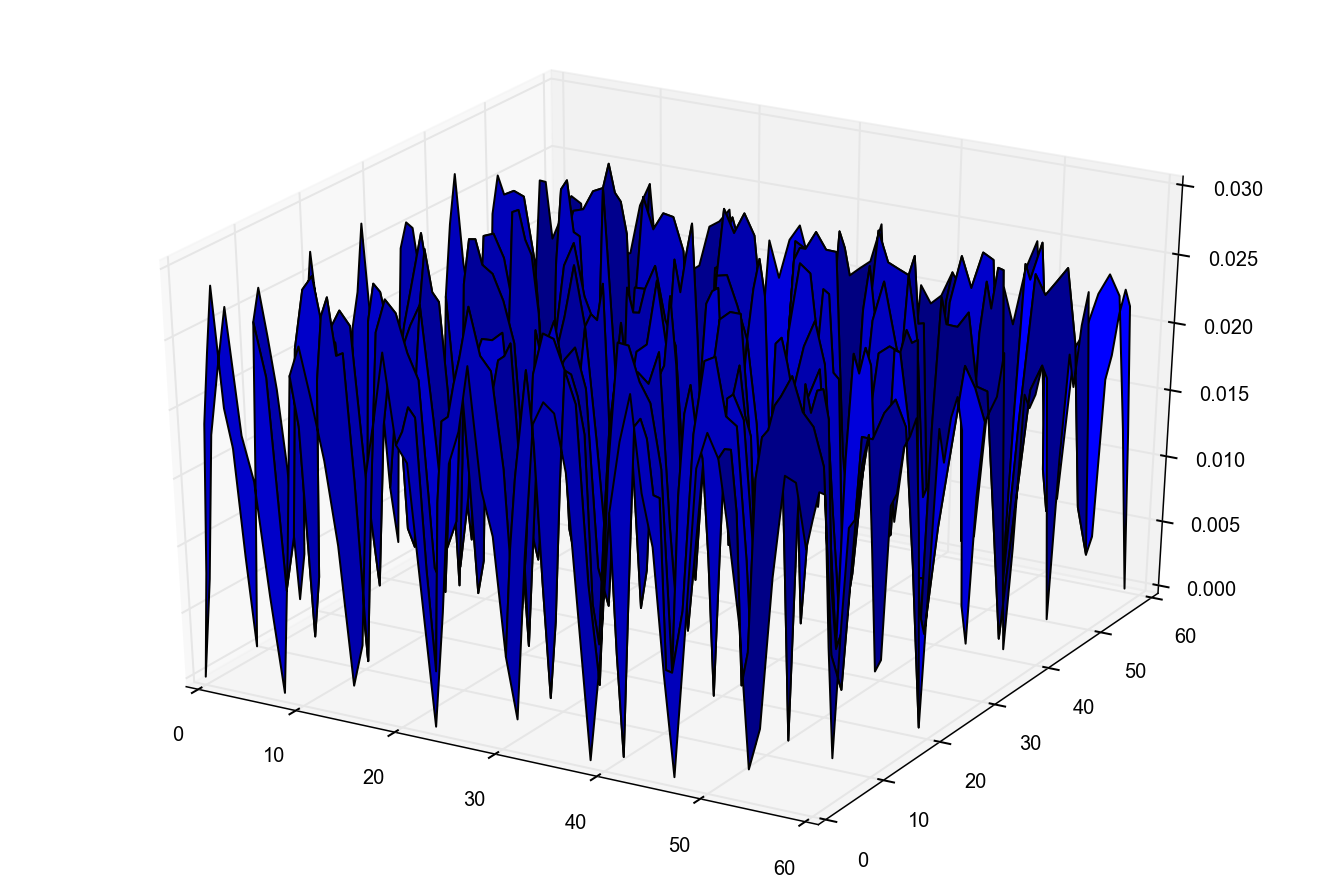

In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0
    for j in range(N):
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
plot_array(Snorm)

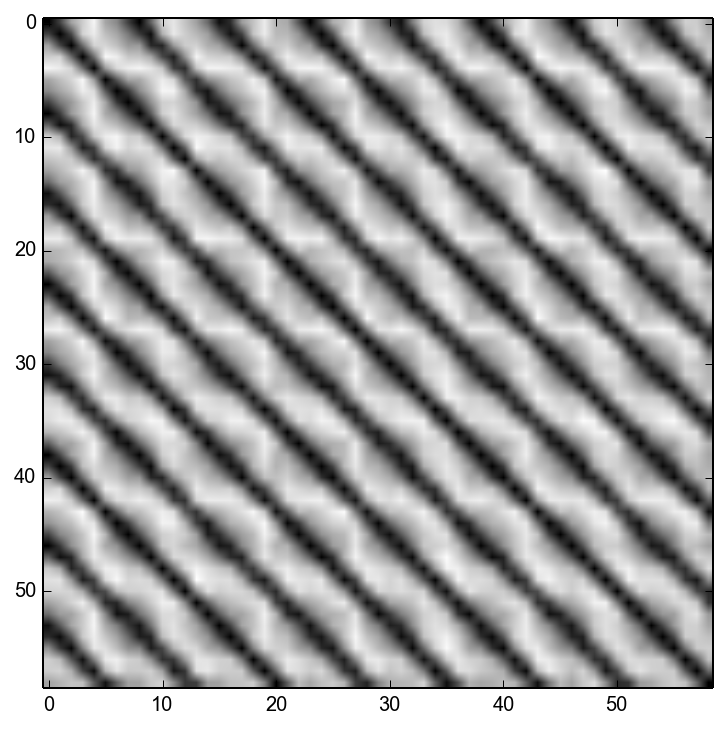

In [10]:
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

In [11]:
Km = int(N / 5)
Snorm_vals, Snorm_vecs = np.linalg.eig(Snorm)
indices = np.argsort(Snorm_vals)[::-1][:Km]
top_vecs = Snorm_vecs[indices].T
#display(top_vecs)

print(Km)
eig_gmm = classify2(top_vecs, Km, Km)

finalK = eig_gmm.n_components

11
n_components 11


In [12]:
final_hmms = []
final_nk = []
top_classes = eig_gmm.predict(top_vecs)
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1.fit(tmp1, tmp1_ls)
    #hmm1.fit(tmp1)
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


In [13]:
for i in range(finalK):                                        
    print(final_hmms[i].transmat_)

[[  8.39846172e-001   0.00000000e+000   1.87873592e-256 ...,
    0.00000000e+000   5.53863276e-002   0.00000000e+000]
 [  0.00000000e+000   8.60215054e-001   0.00000000e+000 ...,
    7.20821726e-071   0.00000000e+000   0.00000000e+000]
 [  7.74788642e-197   2.77827658e-294   7.77522399e-001 ...,
    3.72535174e-002   0.00000000e+000   0.00000000e+000]
 ..., 
 [  0.00000000e+000   0.00000000e+000   1.37859805e-002 ...,
    8.89715257e-001   0.00000000e+000   0.00000000e+000]
 [  2.30769231e-001   0.00000000e+000   0.00000000e+000 ...,
    0.00000000e+000   6.92307692e-001   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   0.00000000e+000 ...,
    0.00000000e+000   0.00000000e+000   8.57142857e-001]]
[[  7.72074941e-001   5.14645712e-143   0.00000000e+000 ...,
    0.00000000e+000   0.00000000e+000   0.00000000e+000]
 [  4.69698058e-168   7.88645458e-001   0.00000000e+000 ...,
    0.00000000e+000   1.24269185e-113   0.00000000e+000]
 [  0.00000000e+000   0.00000000e+000   9.032258

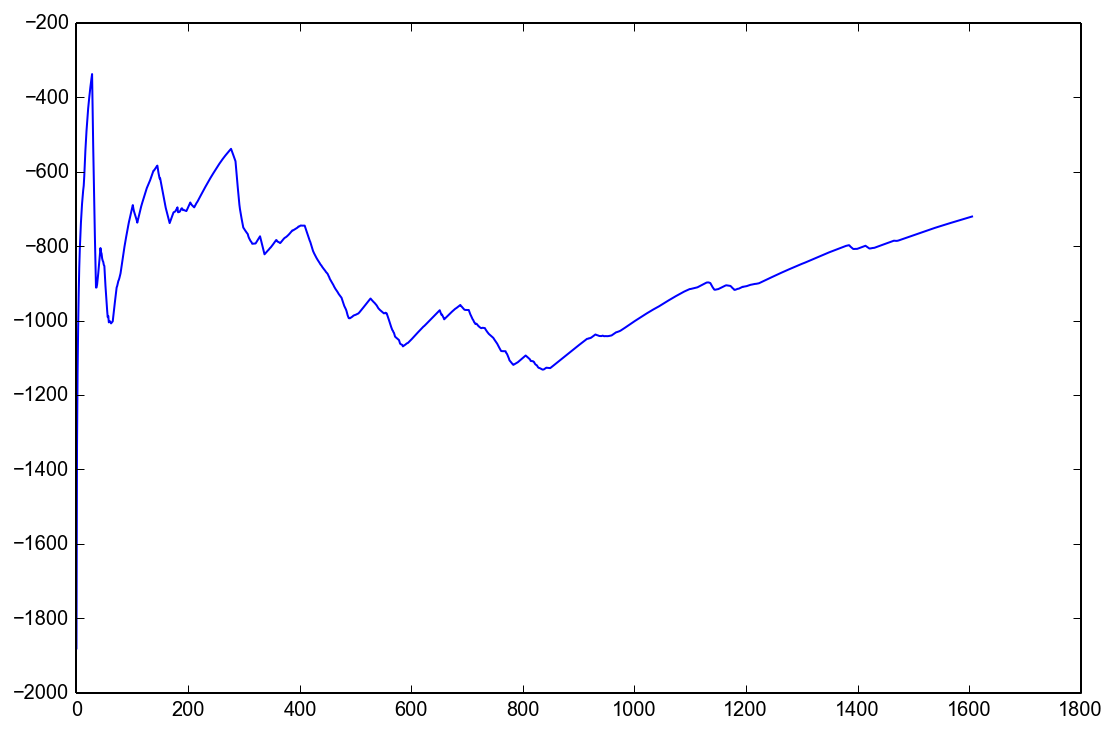

In [14]:
def calc_final_prob(samples):
    res = 0
    for i in range(finalK):                                        
        #res += np.exp(my_hmm_score(final_hmms[i], samples)) * (float(final_nk[i]) / float(N))                    
        res += final_hmms[i].score(samples) * (float(final_nk[i]) / float(N))
    return res

TestPN = df3_test.drop(["time", "frame"], axis=1)
test_arr = []
scrs = []
scrs_prob = []
j = 1
for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)    
    #prb2 = np.log(prb)
    prb2 = prb    
    #if prb2 == -np.inf:
    #    prb2 = -1000;       
    scrs.append(prb2 / j)
    scrs_prob.append(prb)
    j += 1
    if j >= 1700000:
        j -= 1
        del test_arr[0]        
        
plt.figure()
#plt.ylim([-0.1, 1.1])
#plt.plot(scrs_prob)
plt.plot(scrs)
plt.show()

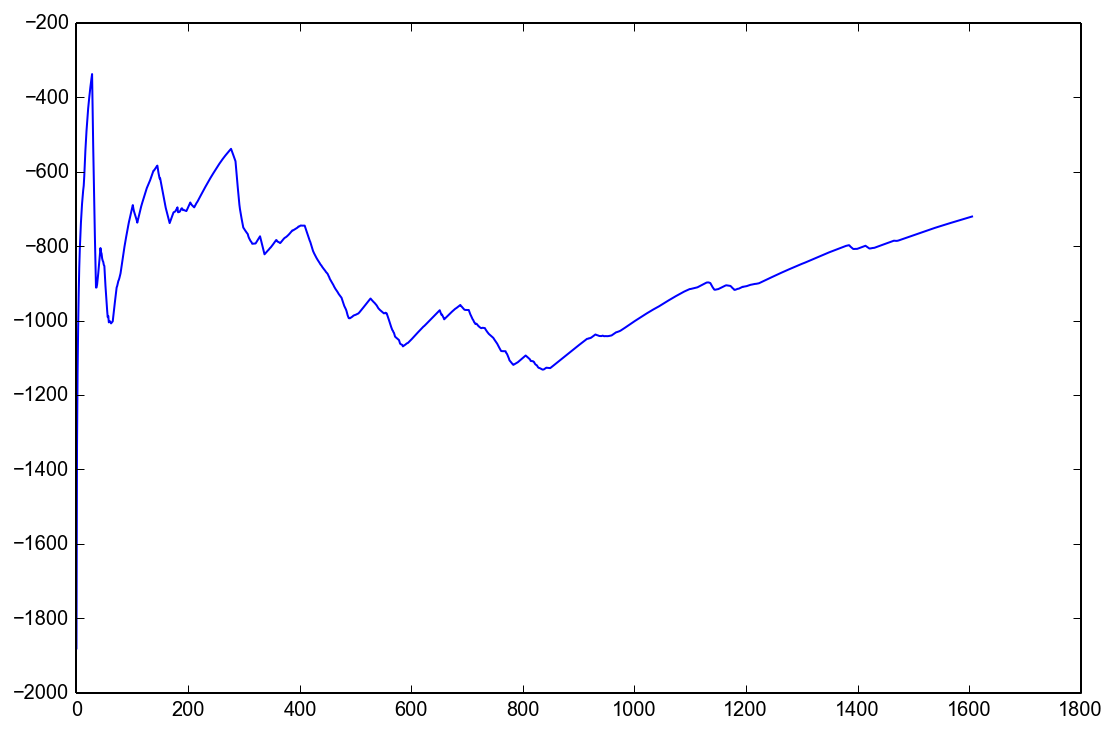

In [15]:
import traceback

Qt = 0
alpha = 0.2

first_frm = 0
first_frm_num = 0

qts = {}
qts_lst = []
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs[i] - scrs[i - 1])        
    Qt = scrs[i]
    qts[df3_test.iloc[i]["frame"]] = Qt
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3_test.iloc[i]["frame"]
            
plt.figure()
plt.plot(qts_lst[first_frm:])
plt.show()

cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < 14.5:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 1
        cv2.imshow('frame', frame)
        k = cv2.waitKey(delay) & 0xff
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()